#Atlanta Store Recommendation System with Analytics and Interactive Map Visualization

This project is a **Store Recommendation System** with analytics and interactive maps.  
It uses store location, category, ratings, and number of reviews to provide recommendations.

#Requirements
pandas
numpy
matplotlib
seaborn
scikit-learn
folium

In [ ]:
# -------------------------------
# Step 1: Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import folium
from folium.plugins import MarkerCluster

In [ ]:
# -------------------------------
# Step 2: Load Dataset
# -------------------------------
df = pd.read_csv("/......../stores.csv")
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (120, 7)


,store_id,store_name,store_type,latitude,longitude,rating,num_reviews
0,1,Clothing Store 1,Clothing,33.687270,-84.277024,4.9,699
1,2,Clothing Store 2,Clothing,33.975357,-84.241563,4.9,684
2,3,Clothing Store 3,Clothing,33.865997,-84.472799,4.8,389
3,4,Clothing Store 4,Clothing,33.799329,-84.555979,3.4,554
4,5,Clothing Store 5,Clothing,33.578009,-84.508826,2.5,938


In [ ]:
# -------------------------------
# Step 2b: Analytics and Visualizations
# ------------------------------

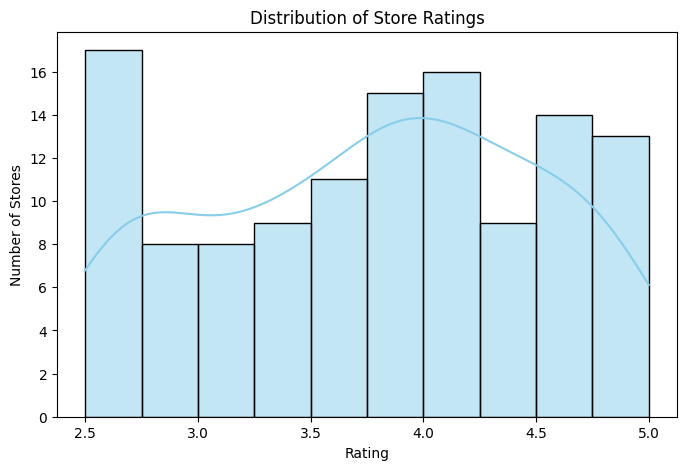

In [ ]:
# 2b. 1. Distribution of store ratings
plt.figure(figsize=(8,5))
sns.histplot(df['rating'], bins=10, kde=True, color='skyblue')
plt.title("Distribution of Store Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Stores")
plt.show()

/tmp/ipython-input-1269989472.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='store_type', order=df['store_type'].value_counts().index, palette="Set3")


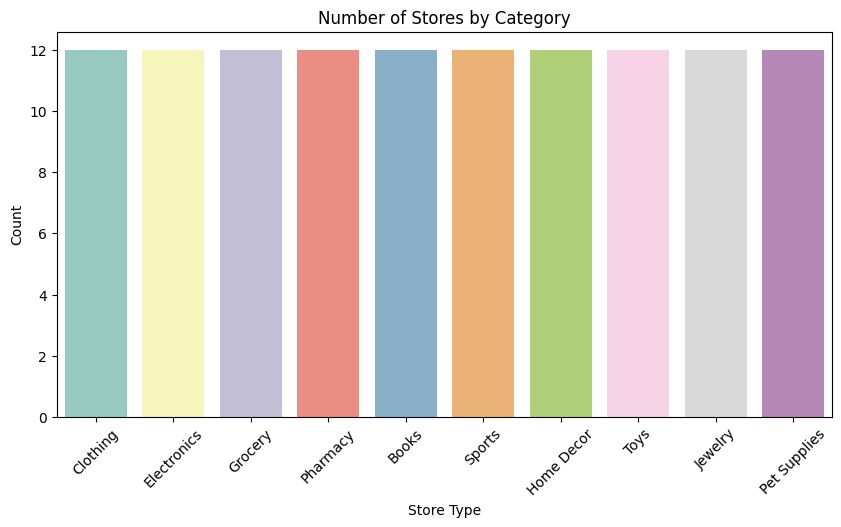

In [ ]:
# 2b. 2. Number of stores by category/type
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='store_type', order=df['store_type'].value_counts().index, palette="Set3")
plt.title("Number of Stores by Category")
plt.xlabel("Store Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

/tmp/ipython-input-1379588143.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rating.index, y=avg_rating.values, palette="coolwarm")


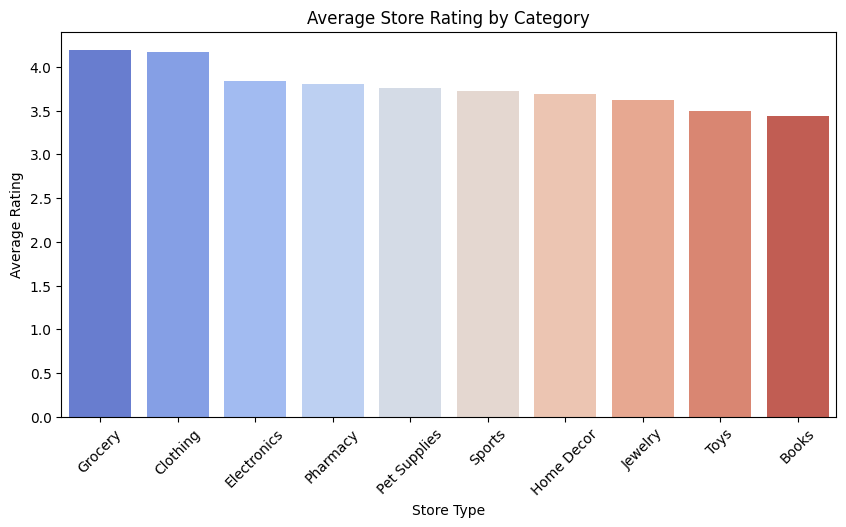

In [ ]:
# 2b. 3. Average rating by store type
avg_rating = df.groupby('store_type')['rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=avg_rating.index, y=avg_rating.values, palette="coolwarm")
plt.title("Average Store Rating by Category")
plt.xlabel("Store Type")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()

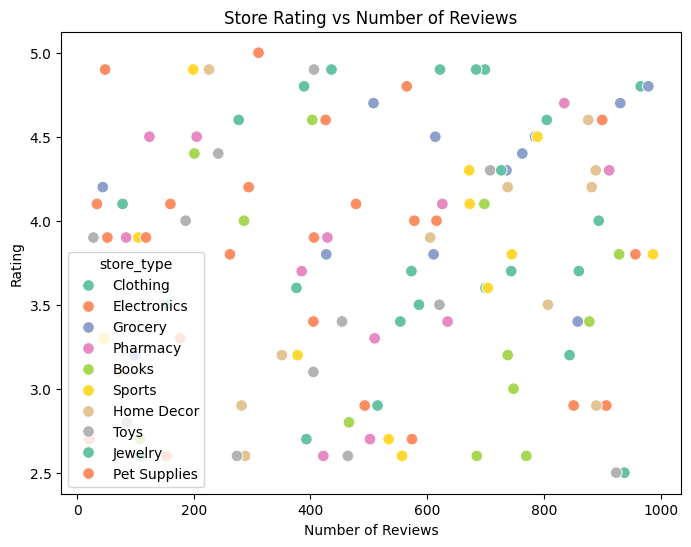

In [ ]:
#2b. 4. Relationship between rating and number of reviews
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='num_reviews', y='rating', hue='store_type', palette="Set2", s=70)
plt.title("Store Rating vs Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Rating")
plt.show()

In [ ]:
# 2b. 5. Top-rated stores overall
top_rated = df.sort_values(by='rating', ascending=False).head(10)
print("Top 10 Stores by Rating:")
print(top_rated[['store_name', 'store_type', 'rating', 'num_reviews']])

Top 10 Stores by Rating:
                store_name    store_type  rating  num_reviews
21    Electronics Store 10   Electronics     5.0          311
0         Clothing Store 1      Clothing     4.9          699
7         Clothing Store 8      Clothing     4.9          436
1         Clothing Store 2      Clothing     4.9          684
8         Clothing Store 9      Clothing     4.9          622
84            Toys Store 1          Toys     4.9          406
73      Home Decor Store 2    Home Decor     4.9          226
65          Sports Store 6        Sports     4.9          199
118  Pet Supplies Store 11  Pet Supplies     4.9           48
16     Electronics Store 5   Electronics     4.8          565


In [ ]:
# -------------------------------
# Step 3: KMeans Clustering
# -------------------------------
kmeans = KMeans(n_clusters=5, random_state=42)
df["cluster"] = kmeans.fit_predict(df[["latitude", "longitude"]])

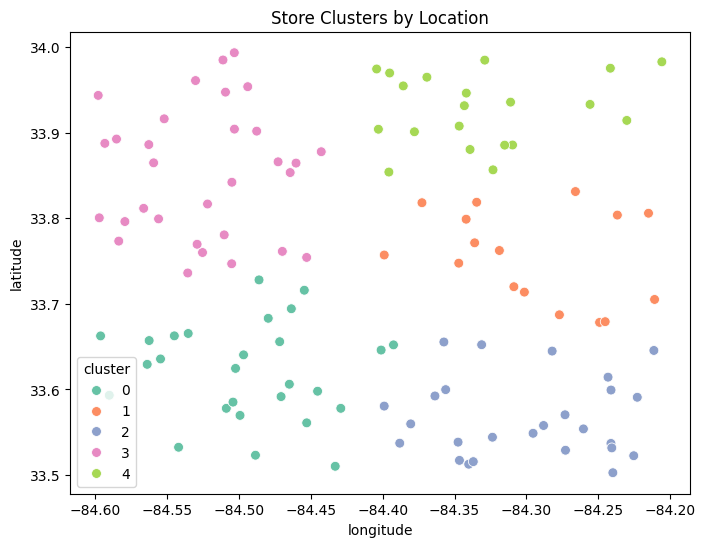

In [ ]:
# Matplotlib scatter plot (optional)
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="longitude", y="latitude", hue="cluster", palette="Set2", s=50)
plt.title("Store Clusters by Location")
plt.show()

In [ ]:
# -------------------------------
# Step 3b: Cluster Map Visualization
# -------------------------------
cluster_map = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()], zoom_start=10)
marker_cluster = MarkerCluster().add_to(cluster_map)

# Add stores to map with cluster color
colors = ["red", "blue", "green", "purple", "orange"]
for _, row in df.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=f"{row['store_name']} ({row['store_type']})\nRating: {row['rating']}, Reviews: {row['num_reviews']}",
        icon=folium.Icon(color=colors[row["cluster"]])
    ).add_to(marker_cluster)

cluster_map

In [ ]:
# -------------------------------
# Step 4: Nearest Store Recommendation
# -------------------------------
def recommend_nearest_stores(lat, lon, n=5):
    nbrs = NearestNeighbors(n_neighbors=n, metric="haversine")
    coords = np.radians(df[["latitude", "longitude"]])
    nbrs.fit(coords)

    distances, indices = nbrs.kneighbors([[np.radians(lat), np.radians(lon)]])
    recs = df.iloc[indices[0]][["store_name", "store_type", "rating", "num_reviews", "latitude", "longitude"]].copy()
    recs["distance_km"] = distances[0] * 6371  # convert radians to km

    # Create map for recommended stores
    rec_map = folium.Map(location=[lat, lon], zoom_start=12)
    folium.Marker(location=[lat, lon], popup="Your Location", icon=folium.Icon(color="black", icon="star")).add_to(rec_map)
    for _, row in recs.iterrows():
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=f"{row['store_name']} ({row['store_type']})\nRating: {row['rating']}, Reviews: {row['num_reviews']}\nDistance: {row['distance_km']:.2f} km",
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(rec_map)
    return recs, rec_map

# Example: Recommend nearest 5 stores to a given location
recs, rec_map = recommend_nearest_stores(33.75, -84.40, n=5)
recs
rec_map

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [ ]:
# -------------------------------
# Step 5: Content-Based Filtering
# -------------------------------
def recommend_by_type(store_type, n=5):
    recs = df[df["store_type"] == store_type].sort_values("rating", ascending=False).head(n)

    # Map for type-based recommendation
    type_map = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()], zoom_start=10)
    for _, row in recs.iterrows():
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=f"{row['store_name']} ({row['store_type']})\nRating: {row['rating']}, Reviews: {row['num_reviews']}",
            icon=folium.Icon(color="green", icon="ok-sign")
        ).add_to(type_map)

    return recs[["store_name", "store_type", "rating", "num_reviews"]], type_map

# Example: Recommend top Clothing stores
clothing_recs, clothing_map = recommend_by_type("Clothing", 5)
clothing_recs
clothing_map